In [1]:
from IPython.display import display, Image

# Understanding RAG Technique

- **Taxonomy of RAG foundations**
- **Paradigms of RAG**
- **Dynamic of Thought Aggregation RAG (DoTA-RAG)**

## Taxonomy of RAG foundations

Ref: https://arxiv.org/abs/2402.19473

### 1. Query-based RAG

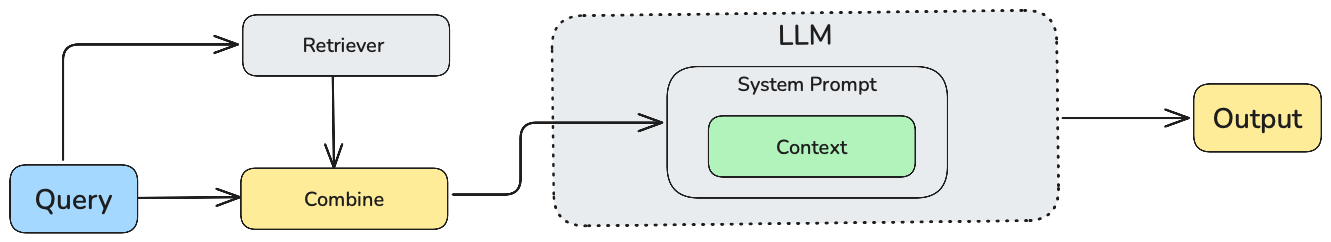

In [4]:
display(Image(filename="images/intro/query_based.png"))

Retrieved documents are directly inserted into the model’s prompt alongside the user query.

Pros:
- Simple to implement
- Provides clear, human-readable context

Cons:
- Prompt length is limited, so you can only add a few docs
- Quality depends heavily on the relevance of retrieved docs

Example: 
- REALM: https://arxiv.org/abs/2002.08909
- DocPrompting: https://arxiv.org/abs/2207.05987


### 2. Latent Representation-based RAG

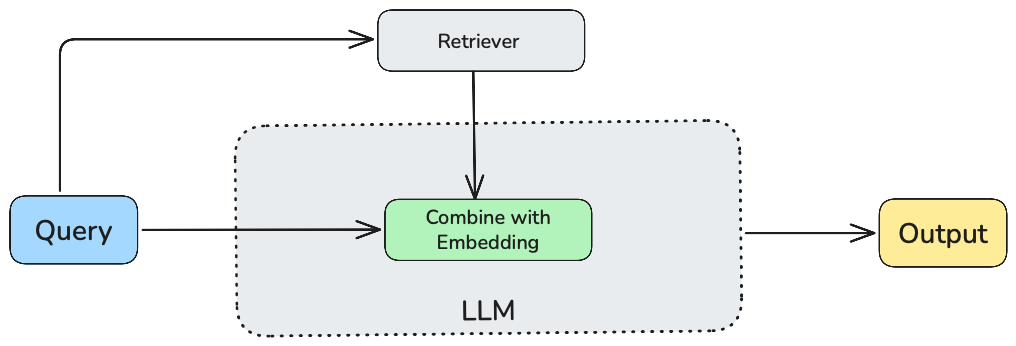

In [5]:
display(Image(filename="images/intro/latent_representation_based.png"))

Instead of text, retrieved docs are encoded into embeddings and injected into the model’s latent space (e.g., via attention layers)

Pros:
- Can handle large amounts of info without prompt-length limits
- Enables nuanced integration inside the model

Cons:
- Architecturally complex
- Requires careful design to blend retrieved embeddings effectively

Example: 
- Retro: https://arxiv.org/abs/2112.04426
- TOME: https://arxiv.org/abs/2110.06176
- Fusion-in-Decoder (FiD): https://aclanthology.org/2021.eacl-main.74/

### 3. Logit-based RAG

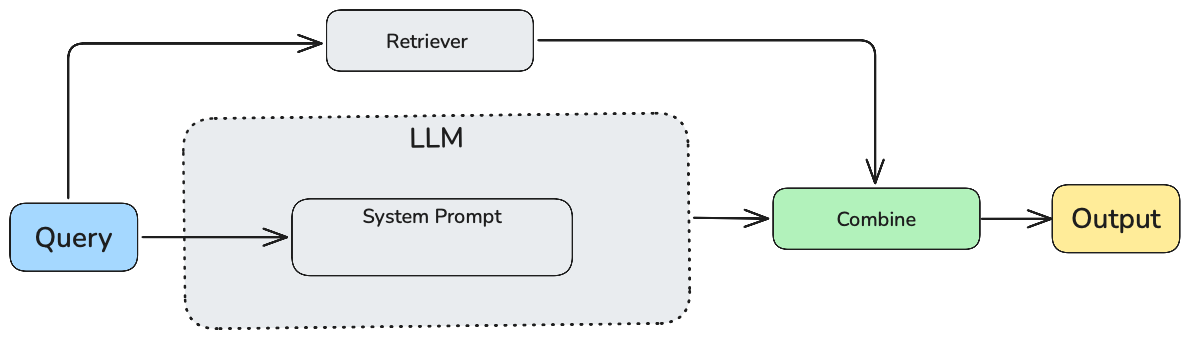

In [6]:
display(Image(filename="images/intro/logit_based.png"))

During token generation, retrieved information adjusts the model’s next-token probabilities (logits)

Pros:
- Precise control at the token level
- Helps reduce hallucinations by grounding choices

Cons:
- Complex integration between retrieval and generation during decoding
- Potentially slower performance

Example:
- Generalization through Memorization (kNN-LM): https://arxiv.org/abs/1911.00172
- Training Language Models with Memory Augmentation (TRIME): https://arxiv.org/abs/2205.12674
- A Retrieve-and-Edit Framework for Source Code Summarization (EditSum): https://arxiv.org/abs/2308.13775


### 4. Speculative RAG 

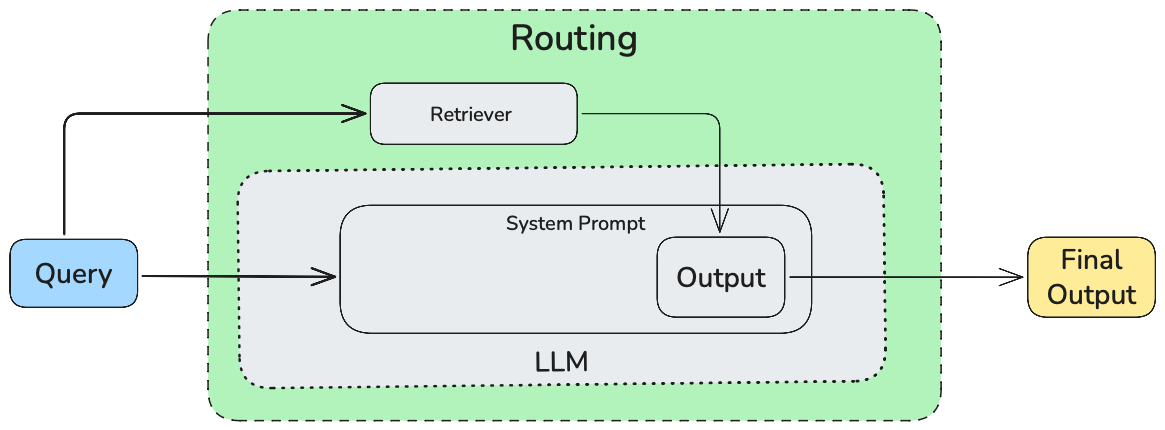

In [7]:
display(Image(filename="images/intro/speculative.png"))


A retrieval-first system that generates draft responses using a lightweight model. The heavy model only verifies or fills in gaps.

Pros:
- More efficient and faster
- Reduces workload on large models

Cons:
- Requires careful orchestration of caching, drafting, and verification
- Tuning complexity to ensure high quality

Example:
- Retrieval-Based Speculative Decoding (REST): https://arxiv.org/abs/2311.08252
- Semantic Cache for LLM Queries (GPTCache): https://github.com/zilliztech/GPTCache
- Copy Is All You Need (COG): https://arxiv.org/abs/2307.06962

### Conclusion

| Method           | Where Retrieval Joins              | Pros                                     | Cons                                     |
| ---------------- | ---------------------------------- | ---------------------------------------- | ---------------------------------------- |
| **Query-based**  | Appended to user prompt            | Simple, easy to read context             | Limited by prompt length                 |
| **Latent-based** | Inside model’s embeddings          | Flexible, scalable, handles lots of info | Model complexity increases               |
| **Logit-based**  | During decoding (logit adjustment) | Fine-grained control, less hallucination | Hard to implement, slower                |
| **Speculative**  | Retrieval & drafting pre-gen       | Fast, resource efficient                 | Complex orchestration, tuning challenges |


## Paradigms of RAG

ref: https://arxiv.org/abs/2312.10997

### 1. Naive RAG

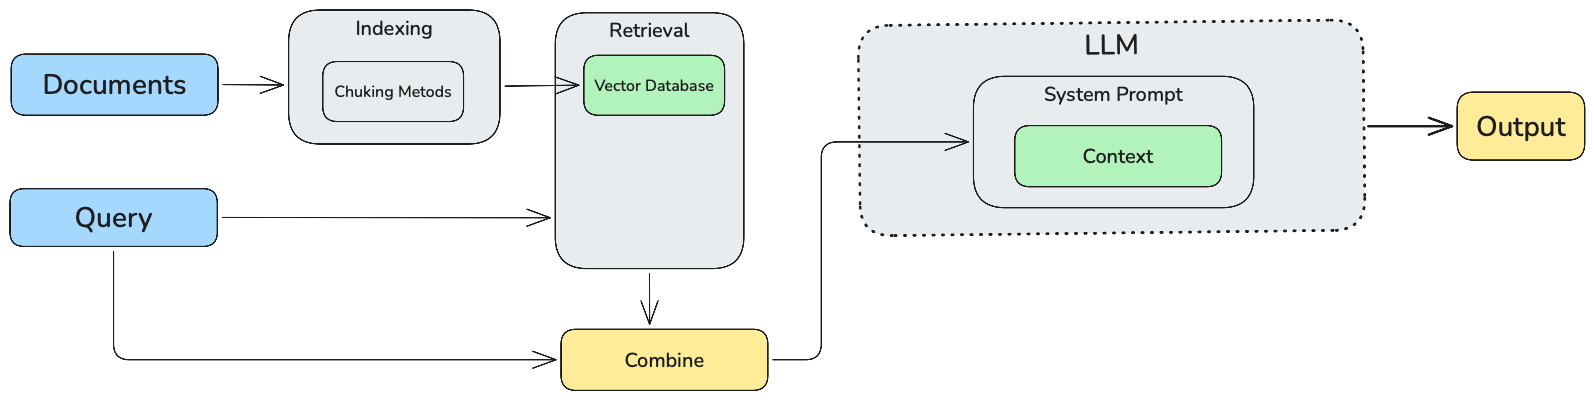

In [8]:
display(Image(filename="images/intro/naive_rag.png"))

Pipeline: Retrieval -> Read -> Generate.
1. Indexing: Documents split into chunks, embedded, and stored in a vector database.
2. Retrieval: Retrieve top K chunks via vector similarity with user query.
3. Generation: Prompt a frozen LLM with [query + retrieved texts] to produce output.

Pros:
-  Simple to implement
-  effective to boost LLM outputs 

Cons:
- Quality depends on retrieved text relevance.
- Prompt size limited by context window.
- Potential hallucinations if mismatched content is inserted 


### 2. Advanced RAG

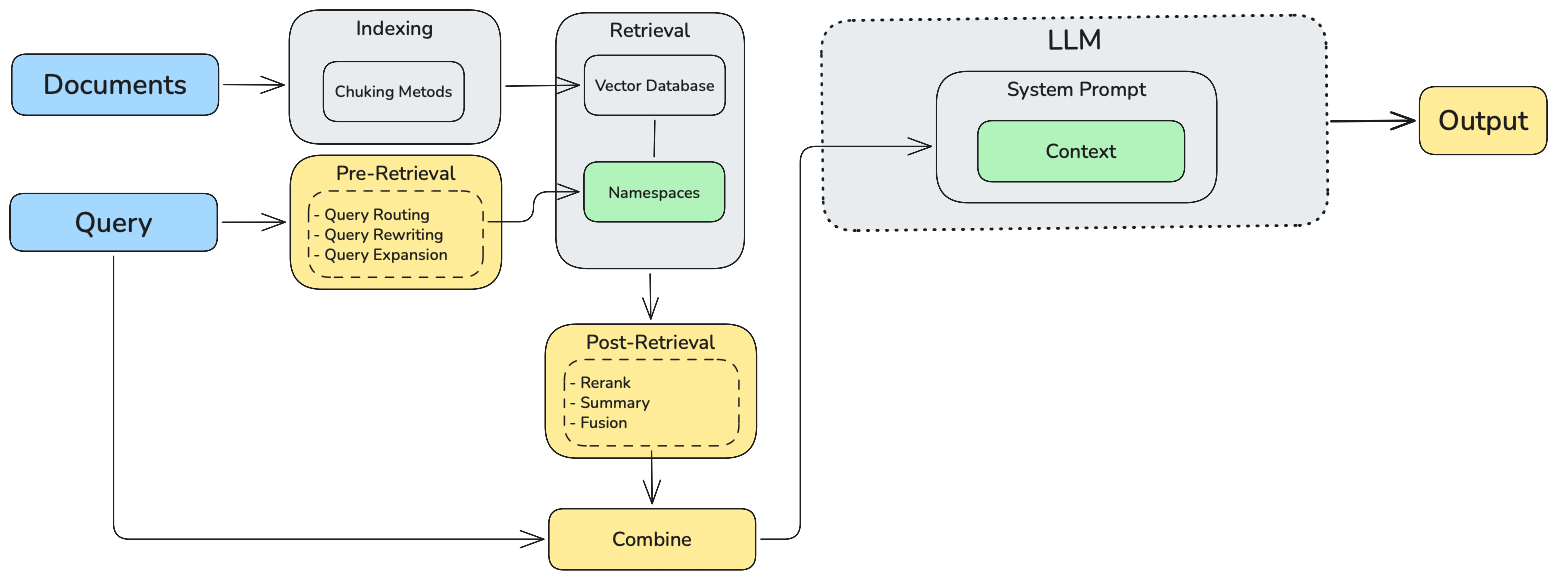

In [9]:
display(Image(filename="images/intro/advanced_rag.png"))

Pipeline:  Retrieve (with prep) → Refine → Prompt LLM → Output. 

Adds two optimization layers around naive pipeline
1. Pre-retrieval enhancements:
- More granular chunking, improved indexing, metadata inclusion.
- Query rewriting/expansion to better articulate user intents.
2. Post-retrieval enhancements:
- Reranking to push the most relevant chunks.
- Summarization or fusion to compress context and avoid irrelevant noise.

Pros:
- Better retrieval precision
- Less noise ratio 

Cons:
- Added complexity in pre/post steps
- Requires careful tuning.

### 3. Modular RAG


Concept: View RAG as a set of interchangeable, specialized modules—not just index/retrieve/generate

Examples of modules:
- Search: Complex or multi-hop search (e.g., SQL/graph queries).
- Memory: Use previous conversation or model outputs to inform current retrieval.
- Fusion: Merge results of multiple retrieved texts or retrieval strategies.
- Routing: Decide dynamically which NLP steps to run (e.g., demo-first, then refine).
- Predict/adapt: Fine-tuning retrievers or adapters per task.

Patterns:
- Linear, iterative (looping), branching, or adaptive flows depending on needs

Pros:
- Extremely flexible
- Supports complex
- Multi-stage retrieval/generation workflows

Cons: 
- System design becomes more elaborate 
- Engineering-intensive

### Conclusion

| Paradigm     | Flow             | Added Layers                       | Benefits                           |
| ------------ | ---------------- | ---------------------------------- | ---------------------------------- |
| **Naive**    | Retrieve -> Read | -                                  | Simplicity, ease of use            |
| **Advanced** | + Pre- and Post- | Query/index prep, rerank, fusion   | Better precision, less noise       |
| **Modular**  | Multi-module     | Search, memory, fusion, routing... | Maximum flexibility and capability |

# Dynamic of Thought Aggregation RAG (DoTA-RAG)

ref: https://arxiv.org/abs/2506.12571

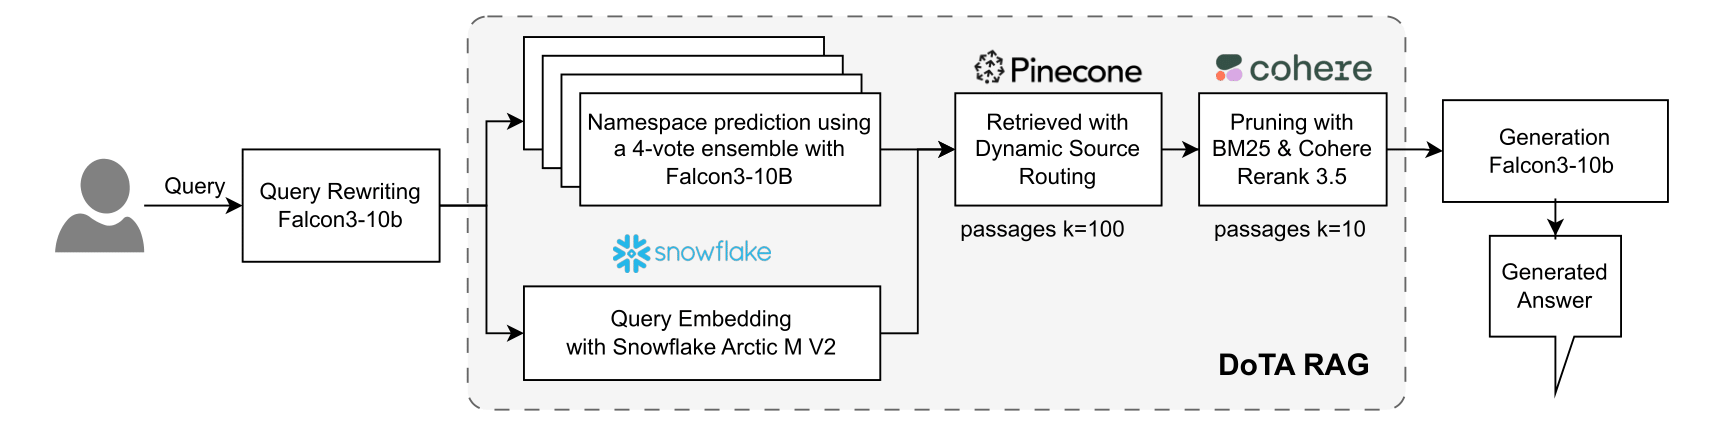

In [10]:
display(Image(filename="images/intro/dotarag.png"))

**Concept**: We focus on enhancing query-based RAG by improving the pre-retrieval stage, specifically through dynamic namespace routing. Our goal is to optimize retrieval efficiency and streamline the overall pipeline.

**Stage‑by‑Stage Pipeline**:
1. Query Rewriting: Uses a low-temperature LLM prompt to normalize, correct, or clean noisy queries (e.g., typos, slang). Helps ensure reliable retrieval performance on misspelled or informal inputs .
2. Dynamic Namespace Routing: Maintains multiple sub-indexes ("namespaces") in Pinecone, each aligned to specific domains/topics. The query to the top-2 namespaces in parallel.
3. Hybrid Retrieval (Multi-Stage) - A layered retrieval strategy combining:  (1)-Dense retrieval: Query embeddings via Snowflake Arctic‑embed‑m‑v2.0 to fetch top 100 candidates. (2)-BM25 pruning: Lexical filtering to reduce to top 20 passages. (3)-Cross-encoder reranking: Uses Cohere’s Rerank 3.5 to select top 10 high-relevance passages. (see embedding leaderboard: https://huggingface.co/spaces/mteb/leaderboard)
4. Context Aggregation:  Concatenate the top 10 passages into a single context, inserting blank lines. If the total length exceeds ~8k tokens, perform proportional truncation across passages.
5. Answer Generation: The final prompt prepends the rewritten query and aggregated context. Feed into <your_model> to produce the answer. (https://huggingface.co/scb10x/typhoon2.1-gemma3-4b)


**Why This Pipeline Matters:**

- Robustness: Query rewriting fixes messy inputs, improving downstream retrieval.
- Speed & Scalability: Routing to targeted sub-indexes significantly reduces latency.
- Precision: Multi-stage retrieval balances semantic breadth and lexical exactness, topped with strong re-ranking.
- Effectiveness: Produces grounded answers under 1 minute per query (median ~35s), with high correctness (~0.93 benchmark score).